# Pre-processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def standard_scale_data(df):
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    scaled_columns = scaler.fit_transform(df.iloc[:, 2:-3])  # Apply scaler to the appropriate columns
    df_scaled.iloc[:, 2:-3] = scaled_columns
    return df_scaled

# Example usage:
# Load your dataset
df_traffic = pd.read_csv('datasets/whole_data.csv')
df_traffic = df_traffic.dropna()

# Normalize the dataset
df_scaled = standard_scale_data(df_traffic)
print(df_scaled.head())
# You can view the normalized data or save it to a new CSV


   Unnamed: 0      Report Date     00:00     00:15     00:30     00:45  \
0           0  Sat 01 Jan 2022  0.057947  0.086811  0.153846  0.213262   
1           1  Sun 02 Jan 2022  0.089404  0.061770  0.096601  0.057348   
2           2  Mon 03 Jan 2022  0.096026  0.095159  0.091234  0.087814   
3           3  Tue 04 Jan 2022  0.089404  0.063439  0.067979  0.073477   
4           4  Wed 05 Jan 2022  0.077815  0.070117  0.087657  0.064516   

      01:00     01:15     01:30     01:45  ...     22:15     22:30     22:45  \
0  0.209350  0.279255  0.318584  0.312102  ...  0.102294  0.170111  0.112696   
1  0.067073  0.079787  0.082596  0.095541  ...  0.130019  0.189189  0.135521   
2  0.073171  0.132979  0.067847  0.082803  ...  0.103250  0.173291  0.101284   
3  0.091463  0.095745  0.100295  0.114650  ...  0.121415  0.179650  0.136947   
4  0.095528  0.098404  0.100295  0.133758  ...  0.126195  0.197138  0.162625   

      23:00     23:15     23:30     23:45    Total        label  null_coun

# Modelling

 ## create the tensor datasets

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Assuming df_normalized is your DataFrame
# Convert the DataFrame to a tensor, ignoring the 'Sensor_ID' column
data = torch.tensor(df_scaled.iloc[:, 2:-3].values, dtype=torch.float32)
# print(df_normalized.iloc[:, 2:-2].head())
# Create a dataset where inputs are the same as labels (autoencoder structure)
dataset = TensorDataset(data, data)
print(dataset)

In [3]:
# Splitting the dataset into 80% training and 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


## modelling - pytorch autoencoder

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            # nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),
            # nn.ReLU(True)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
input_size = data.shape[1]  # Number of features
model = Autoencoder(input_size)


In [5]:
def train_model(model, train_loader, test_loader, num_epochs=300):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        
        # Calculate average loss
        train_loss = train_loss / len(train_loader.dataset)
        
        # Evaluate on test setA
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item() * data.size(0)
        test_loss = test_loss / len(test_loader.dataset)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Usage example:
train_model(model, train_loader, test_loader, num_epochs=200)


Epoch 1, Train Loss: 0.0857, Test Loss: 0.0153
Epoch 2, Train Loss: 0.0135, Test Loss: 0.0118
Epoch 3, Train Loss: 0.0099, Test Loss: 0.0098
Epoch 4, Train Loss: 0.0084, Test Loss: 0.0084
Epoch 5, Train Loss: 0.0070, Test Loss: 0.0065
Epoch 6, Train Loss: 0.0052, Test Loss: 0.0048
Epoch 7, Train Loss: 0.0041, Test Loss: 0.0039
Epoch 8, Train Loss: 0.0034, Test Loss: 0.0032
Epoch 9, Train Loss: 0.0029, Test Loss: 0.0028
Epoch 10, Train Loss: 0.0026, Test Loss: 0.0025
Epoch 11, Train Loss: 0.0023, Test Loss: 0.0023
Epoch 12, Train Loss: 0.0021, Test Loss: 0.0021
Epoch 13, Train Loss: 0.0020, Test Loss: 0.0020
Epoch 14, Train Loss: 0.0019, Test Loss: 0.0020
Epoch 15, Train Loss: 0.0019, Test Loss: 0.0019
Epoch 16, Train Loss: 0.0018, Test Loss: 0.0018
Epoch 17, Train Loss: 0.0018, Test Loss: 0.0018
Epoch 18, Train Loss: 0.0017, Test Loss: 0.0017
Epoch 19, Train Loss: 0.0017, Test Loss: 0.0017
Epoch 20, Train Loss: 0.0016, Test Loss: 0.0017
Epoch 21, Train Loss: 0.0016, Test Loss: 0.0016
E

/opt/conda/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

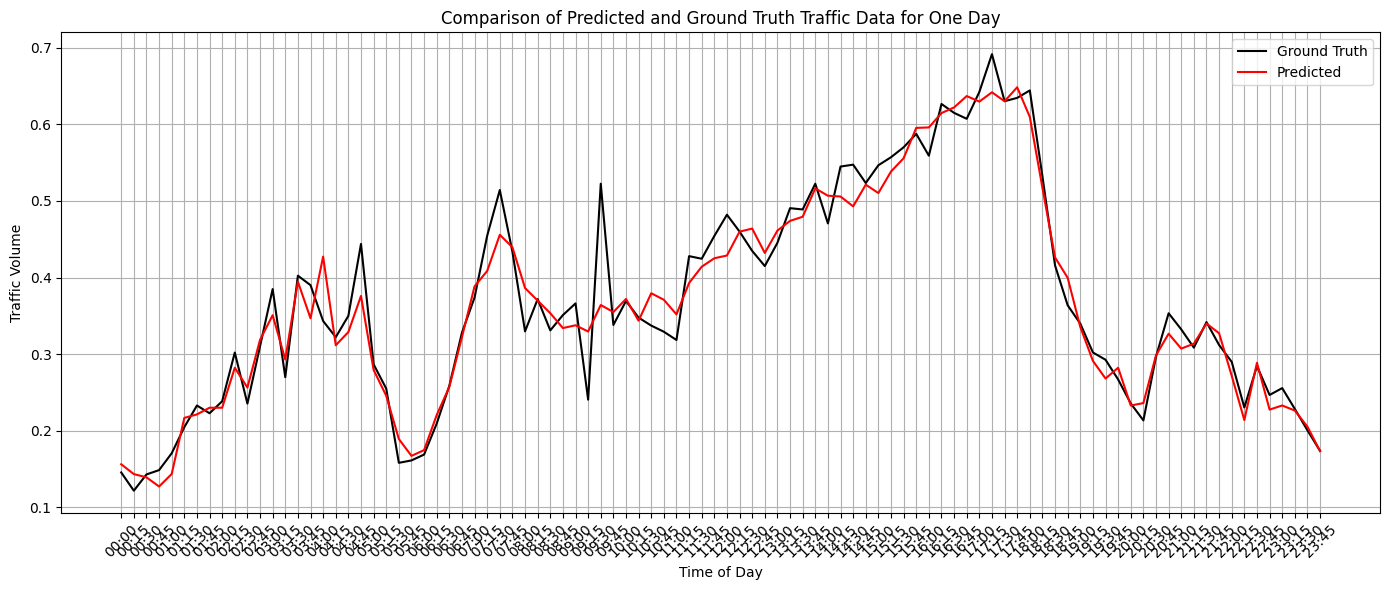

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_sample_prediction(model, data_loader, sample_index=0):
    model.eval()  # Set the model to evaluation mode
    cumulative_count = 0  # To keep track of the cumulative number of samples processed

    with torch.no_grad():
        for data, target in data_loader:
            if cumulative_count <= sample_index < cumulative_count + len(data):
                # Calculate the local index within the current batch
                local_index = sample_index - cumulative_count
                output = model(data)
                actual_data = target[local_index].numpy()
                predicted_data = output[local_index].numpy()
                
                # Creating a time series index for plotting (e.g., 96 intervals for a day)
                time_series = [f"{(i*15)%1440//60:02d}:{(i*15)%60:02d}" for i in range(len(actual_data))]
                
                # Plotting
                plt.figure(figsize=(14, 6))
                sns.lineplot(x=time_series, y=actual_data, label='Ground Truth', color='black', linewidth=1.5)
                sns.lineplot(x=time_series, y=predicted_data, label='Predicted', color='red', linewidth=1.5)
                plt.title('Comparison of Predicted and Ground Truth Traffic Data for One Day')
                plt.xlabel('Time of Day')
                plt.ylabel('Traffic Volume')
                plt.xticks(rotation=45)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
                return  # Exit the function after plotting

            cumulative_count += len(data)  # Update the cumulative count

    print(f"Sample index {sample_index} is out of range for the available data.")

# Example usage, this should now work correctly across the entire test dataset
plot_sample_prediction(model, test_loader, sample_index=100)


In [33]:
def calculate_residuals(model, data_loader):
    residuals = []
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            reconstructed = model(data)
            residual = torch.abs(data - reconstructed)
            residuals.append(residual)
    return torch.cat(residuals, 0)


def max_residuals_by_date_location(residuals, df_scaled):
    # Reshape residuals to match the original DataFrame size
    residuals = residuals.numpy()
    
    # Create a DataFrame from residuals with the same indexing as df_scaled
    residual_df = pd.DataFrame(residuals, columns=df_scaled.columns[2:-3], index=df_scaled.index)
    residual_df['Report Date'] = df_scaled['Report Date']
    residual_df['label'] = df_scaled['label']
    
    # Calculate the max residual for each row, considering only the numerical columns (all columns except 'Report Date' and 'label')
    residual_df['Max Residual'] = residual_df.loc[:, df_scaled.columns[2:-3]].max(axis=1)
    
    # Group by date and location, and find max residual per group
    max_residuals = residual_df.groupby(['Report Date', 'label'])['Max Residual'].max().reset_index()
    
    return max_residuals

def max_residuals_by_date_location(residuals, df_scaled):
    # Reshape residuals to match the original DataFrame size
    residuals = residuals.numpy()
    
    # Create a DataFrame from residuals with the same indexing as df_scaled
    residual_df = pd.DataFrame(residuals, columns=df_scaled.columns[2:-3], index=df_scaled.index)
    
    # Add date and label columns for reference
    residual_df['Report Date'] = df_scaled['Report Date'].values
    residual_df['label'] = df_scaled['label'].values
    
    # Calculate the max residual for each row, considering only the numerical columns (all columns except 'Report Date' and 'label')
    residual_df['Max Residual'] = residual_df.loc[:, df_scaled.columns[2:-3]].max(axis=1)
    
    # Group by 'Report Date' and 'label', selecting all features
    grouped_residuals = residual_df.groupby(['Report Date', 'label']).agg({col: 'max' for col in residual_df.columns if col not in ['Report Date', 'label']}).reset_index()
    
    return grouped_residuals


def save_residuals(max_residuals, filename='max_residuals.csv'):
    max_residuals.to_csv(filename)

In [34]:
# Assuming you've already loaded your data and trained your model:
all_data_loader = DataLoader(dataset, batch_size=128, shuffle=False)
residuals = calculate_residuals(model, all_data_loader)

# Calculate aggregated residuals grouped by date and location:
grouped_residuals = max_residuals_by_date_location(residuals, df_scaled)

# Save the DataFrame to a CSV:
grouped_residuals.to_csv('grouped_residuals_by_date_and_location.csv', index=False)
